In [1]:
import pandas as pd
import numpy as np
import simfin as sf
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


# Set the plotting DPI settings to be a bit higher.
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

path = './Mock/'
def mergeAnnualBalanceCashflow(path=path):
    incomeStatement = pd.read_csv(path + 'us-income-annual.csv', delimiter=';')
    balanceSheet = pd.read_csv(path + 'us-balance-annual.csv', delimiter = ';')
    cashflow = pd.read_csv(path + 'us-cashflow-annual.csv', delimiter = ';')
    
    columns = ['Ticker', 'SimFinId', 'Currency', 'Fiscal Year', 'Report Date', 'Publish Date']
    result = pd.merge(incomeStatement,
                      balanceSheet,
                      on=columns).merge(cashflow, on=columns)
    result['Report Date'] = pd.to_datetime(result['Report Date'])
    result['Publish Date'] = pd.to_datetime(result['Publish Date'])
    
    print('Income Statement CSV data is(rows, columns): ', incomeStatement.shape)
    print('Balance Sheet CSV data is: ', balanceSheet.shape)
    print('Cash Flow CSV data is: ', cashflow.shape)
    print('Matrix shape is', result.shape)
    
    return result


def getDailyPrices(path=path):
    sf.set_api_key('free')
    sf.set_data_dir(path)
    df = sf.load_shareprices(variant='daily', market='us')
    df.reset_index(inplace=True)
    print('Daily price matrix', df.shape)
    return df

In [2]:
def getDailyPricesByDate(ticker, date, modifier, dailyPrices):
    tickerData = dailyPrices[dailyPrices['Ticker'] == ticker]
    
    windowDays = 5
    
    rows = dailyPrices[
        (dailyPrices['Date'].between(pd.to_datetime(date) +
                                         pd.Timedelta(days=modifier),
                                         pd.to_datetime(date) +
                                         pd.Timedelta(days=windowDays + modifier)))
        & (dailyPrices['Ticker']==ticker)]
    
    if rows.empty:
        return [ticker, np.float('NaN'), np.datetime64('NaT'), np.float('NaN')]
    else:
        return [ticker,
                rows.iloc[0]['Open'],
                rows.iloc[0]['Date'],
                rows.iloc[0]['Volume'] * rows.iloc[0]['Open']]

# getDailyPricesByDate('AAPL', '2012-05-12', 0)


def getYPricesReportDateAndTargetDate(x, d):
    '''
    Takes in all fundamental data X, all stock prices over time y,
    and modifier (days), and returns the stock price info for the
    data report date, as well as the stock price one year from that date
    (if modifier is left as modifier=365)
    '''
    # Preallocation list of list of 2
    # [(price at date) (price at date + modifier)]

    y = [[None]*8 for i in range(len(x))]
    # or 'Report Date',
    # is the performance date from->to. Want this to be publish date.
    # Because of time lag between report date
    # (which can't be actioned on) and publish date
    # (data we can trade with)
    i=0
    for index in range(len(x)):
        ticker = x['Ticker'].iloc[index]
        currentYear = getDailyPricesByDate(ticker, x['Publish Date'].iloc[index], 0, d)
        nextYear = getDailyPricesByDate(ticker, x['Publish Date'].iloc[index], 365, d)
        y[i]=(currentYear + nextYear)
        i = i + 1
        print(index)
    return y

# def getYPricesReportDateAndTargetDate(x, d, modifier=365):
#     '''
#     Takes in all fundamental data X, all stock prices over time y,
#     and modifier (days), and returns the stock price info for the
#     data report date, as well as the stock price one year from that date
#     (if modifier is left as modifier=365)
#     '''
#     # Preallocation list of list of 2 
#     # [(price at date) (price at date + modifier)]
#     y = [[None]*8 for i in range(len(x))] 
    
#     whichDateCol='Publish Date'# or 'Report Date', 
#     # is the performance date from->to. Want this to be publish date.
    
#     # Because of time lag between report date
#     # (which can't be actioned on) and publish date
#     # (data we can trade with)
    
#     # In the end decided this instead of iterating through index.
#     # Iterate through a range rather than index, as X might not have
#     # monotonic increasing index 1, 2, 3, etc.
#     i=0
#     for index in range(len(x)):
#         y[i]=(getDailyPricesByDate(x['Ticker'].iloc[index], 
#                                     x[whichDateCol].iloc[index],0,d)
#               + getDailyPricesByDate(x['Ticker'].iloc[index], 
#                                      x[whichDateCol].iloc[index], 
#                                      modifier, d))
#         i=i+1
#         print(i)
#     return y

    


In [38]:
# y = getYPricesReportDateAndTargetDate(mergeAnnualBalanceCashflow(), getDailyPrices())
x = mergeAnnualBalanceCashflow()
y = pd.read_csv(path + 'y_data.csv')
y = pd.DataFrame(y, columns=['Ticker', 'Open Price', 'Date', 'Volume', 'Ticker2', 'Open Price2', 'Date2', 'Volume2'])
y.to_csv(path + 'Annual_Stock_Price_Performance.csv')

Income Statement CSV data is(rows, columns):  (20239, 28)
Balance Sheet CSV data is:  (20239, 30)
Cash Flow CSV data is:  (20239, 28)
Matrix shape is (20239, 74)


array([[<AxesSubplot:xlabel='Revenue', ylabel='Revenue'>,
        <AxesSubplot:xlabel='Net Income', ylabel='Revenue'>],
       [<AxesSubplot:xlabel='Revenue', ylabel='Net Income'>,
        <AxesSubplot:xlabel='Net Income', ylabel='Net Income'>]],
      dtype=object)

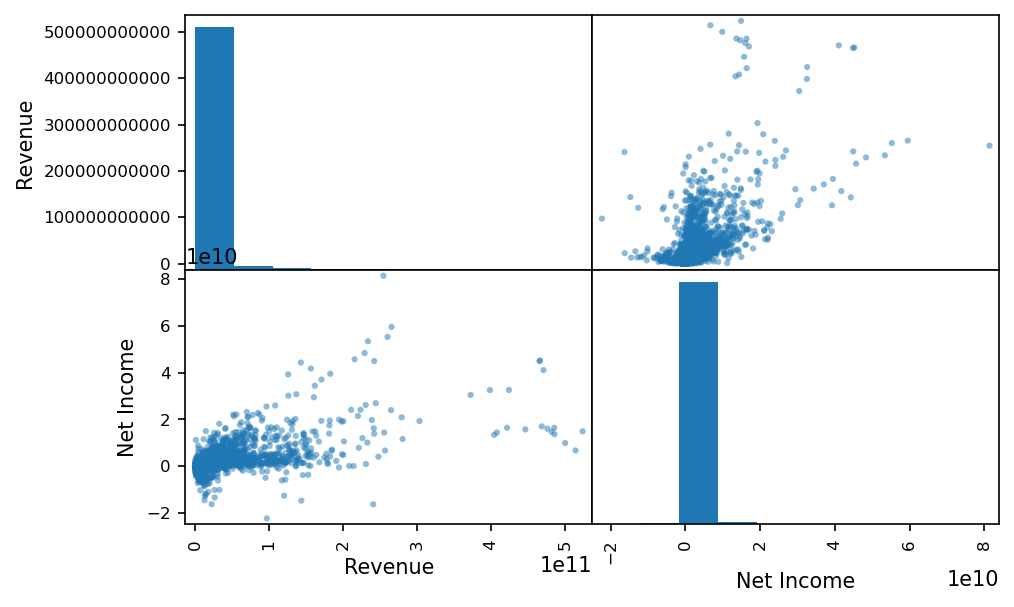

In [4]:
scatter_matrix(x[['Revenue', 'Net Income']])

In [5]:
y = pd.read_csv('Annual_Stock_Price_Performance.csv')
x['Market Cap'] = y['Open Price'] * x['Shares (Diluted)_x']
x.to_csv('Annual_Stock_Price_Fundamentals.csv')

# Remove rows where there is no share price
bool_list = ~y['Open Price'].isnull()
y = y[bool_list]
x = x[bool_list]

# Remove rows where there is no listed number of shares
bool_list = ~x['Shares (Diluted)_x'].isnull()
y = y[bool_list]
x = x[bool_list]

# Remove rows that are being traded less than 10,000 shares per day
bool_list = ~((y['Volume'] < 1e4) | (y['Volume2'] < 1e4))
y = y[bool_list]
x = x[bool_list]

# Remove rows where dates are missing
bool_list = ~y['Date2'].isnull()
y = y[bool_list]
x = x[bool_list]

y = y.reset_index(drop=True)
x = x.reset_index(drop=True)

x.to_csv(path + 'Annual_Stock_Price_Fundamentals_Filtered.csv')
y.to_csv(path + 'Annual_Stock_Price_Performance_Filtered.csv')

print("X Shape:", x.shape)
print("Y Shape:", y.shape)

def fixNansInX(x):
    keyCheckNullList = ["Short Term Debt", "Long Term Debt" ,
                        "Interest Expense, Net", "Income Tax (Expense) Benefit, Net",
                        "Cash, Cash Equivalents & Short Term Investments",
                        "Property, Plant & Equipment, Net", "Revenue", "Gross Profit"]

    x[keyCheckNullList] = x[keyCheckNullList].fillna(0)
    
    return x
    
def addColsToX(x):
    x['EV'] = x['Market Cap'] + x['Long Term Debt'] + x['Short Term Debt'] - x['Cash, Cash Equivalents & Short Term Investments']
    x['EBIT'] = x['Net Income'] - x['Interest Expense, Net'] - x['Income Tax (Expense) Benefit, Net']
    return x

def getRatios(df):
    df2 = pd.DataFrame()
    
    market_cap = df['Market Cap']
    net_income = df['Net Income']
    ev = df['EV']
    ebit = df['EBIT']
    operating_income = df['Operating Income (Loss)']
    total_assets = df['Total Assets']
    current_assets = df['Total Current Assets']
    total_liabilities = df['Total Liabilities']
    current_liabilities = df['Total Current Liabilities']
    net_working_capital = current_assets - current_liabilities
    tangible_assets = df['Property, Plant & Equipment, Net']
    total_equity = df['Total Equity']
    revenue = df['Revenue']
    interest_expense = df['Interest Expense, Net']
    cash = df['Cash, Cash Equivalents & Short Term Investments']
    gross_profit = df['Gross Profit']
    retained_earnings = df['Retained Earnings']
    
    # Enterprise Value / Ebit
    df2['EV/EBIT'] = ev / ebit
    
    # Operating income / (Net Working Capital (NWC) + Tangible Fixed Assets (FA))
    df2['Op. In./(NWC+FA)'] = operating_income / (net_working_capital + tangible_assets)
    
    # Price to Earnings (P/E)
    df2['P/E'] = market_cap / net_income
    
    # Price to Book Value (P/B)
    df2['P/B'] = market_cap / total_equity
    
    # Price to Sales (P/S)
    df2['P/S'] = market_cap / revenue
    
    # Operating Income / Interest Expense
    df2["Op. In./Interest Expense"] = operating_income / (- interest_expense)
    
    # Working Capital Ratio
    df2['Working Capital Ratio'] = current_assets / current_liabilities
    
    # Return on Equity
    df2['ROE'] = net_income / total_equity
    
    # Return on Capital Employed
    df2['ROCE'] = ebit / (total_assets - current_liabilities)
    
    # Debt/Equity
    df2["Debt/Equity"] = total_liabilities / total_equity
    
    # Debt Ratio
    df2["Debt Ratio"] = total_assets / total_liabilities
    
    # Cash Ratio
    df2['Cash Ratio'] = cash / current_liabilities
    
    # Asset Turnover
    df2['Asset Turnover'] = revenue / tangible_assets
    
    # Gross Profit Margin
    df2['Gross Profit Margin'] = gross_profit / revenue
    
    ### Altman ratios ###
    # (Current assets - current liabilities) / total assets
    df2['(CA-CL)/TA'] = (current_assets - current_liabilities) / total_assets
    
    # RE/TA
    df2['RE/TA'] = retained_earnings / total_assets
    
    # EBIT/TA
    df2['EBIT/TA'] = ebit / total_assets
    
    # Book Equity/TL
    df2['Book Equity/TL'] = total_equity / total_liabilities
    
    df2.fillna(0, inplace=True)
    return df2

# removing outliers on x dataframe

def removeOutliers(df):
    # clipping is done manually by eye through data observation
    df['ROE'].clip(-5, 5, inplace=True)
    df['Op. In./(NWC+FA)'].clip(-5, 5, inplace=True)
    df['EV/EBIT'].clip(-500, 500, inplace=True)
    df['P/E'].clip(-1000, 1000, inplace=True)
    df['P/B'].clip(-50, 100, inplace=True)
    df['P/S'].clip(0, 500, inplace=True)
    df['Op. In./Interest Expense'].clip(-600, 600, inplace=True)
    df['Working Capital Ratio'].clip(0, 30, inplace=True)
    df['ROCE'].clip(-2, 2, inplace=True)
    df['Debt/Equity'].clip(0, 100, inplace=True)
    df['Debt Ratio'].clip(0, 50, inplace=True)
    df['Cash Ratio'].clip(0, 30, inplace=True)
    df['Gross Profit Margin'].clip(0, 1, inplace=True) #how can be >100%?
    df['(CA-CL)/TA'].clip(-1.5, 2, inplace=True)
    df['RE/TA'].clip(-20, 2, inplace=True)
    df['EBIT/TA'].clip(-2, 1, inplace=True)
    df['Book Equity/TL'].clip(-2, 20, inplace=True)
    df['Asset Turnover'].clip(0, 500, inplace=True)
    
    return df

def getAnnualPerformance(df):
    df['Performance'] = (df['Open Price2'] - df['Open Price']) / df['Open Price']
    df['Performance'].fillna(0, inplace=True)
    columns = ['Ticker', 'Performance']
    return df[columns]
    
# k=x.keys()[2] #14 max
# x[k].hist(bins=100, figsize=(5,5))
# plt.title(k);

X Shape: (15715, 75)
Y Shape: (15715, 9)


In [20]:
x = pd.read_csv(path + 'Annual_Stock_Price_Fundamentals_Filtered.csv', index_col=0)
y = pd.read_csv(path + 'Annual_Stock_Price_Performance_Filtered.csv', index_col=0)

x = fixNansInX(x)
x = addColsToX(x)
x = getRatios(x)
x = removeOutliers(x)

x.to_csv(path + 'Annual_Stock_Price_Fundamentals_Ratios.csv')

y = getAnnualPerformance(y)
y.to_csv(path + 'Annual_Stock_Price_Performance_Percentage.csv')

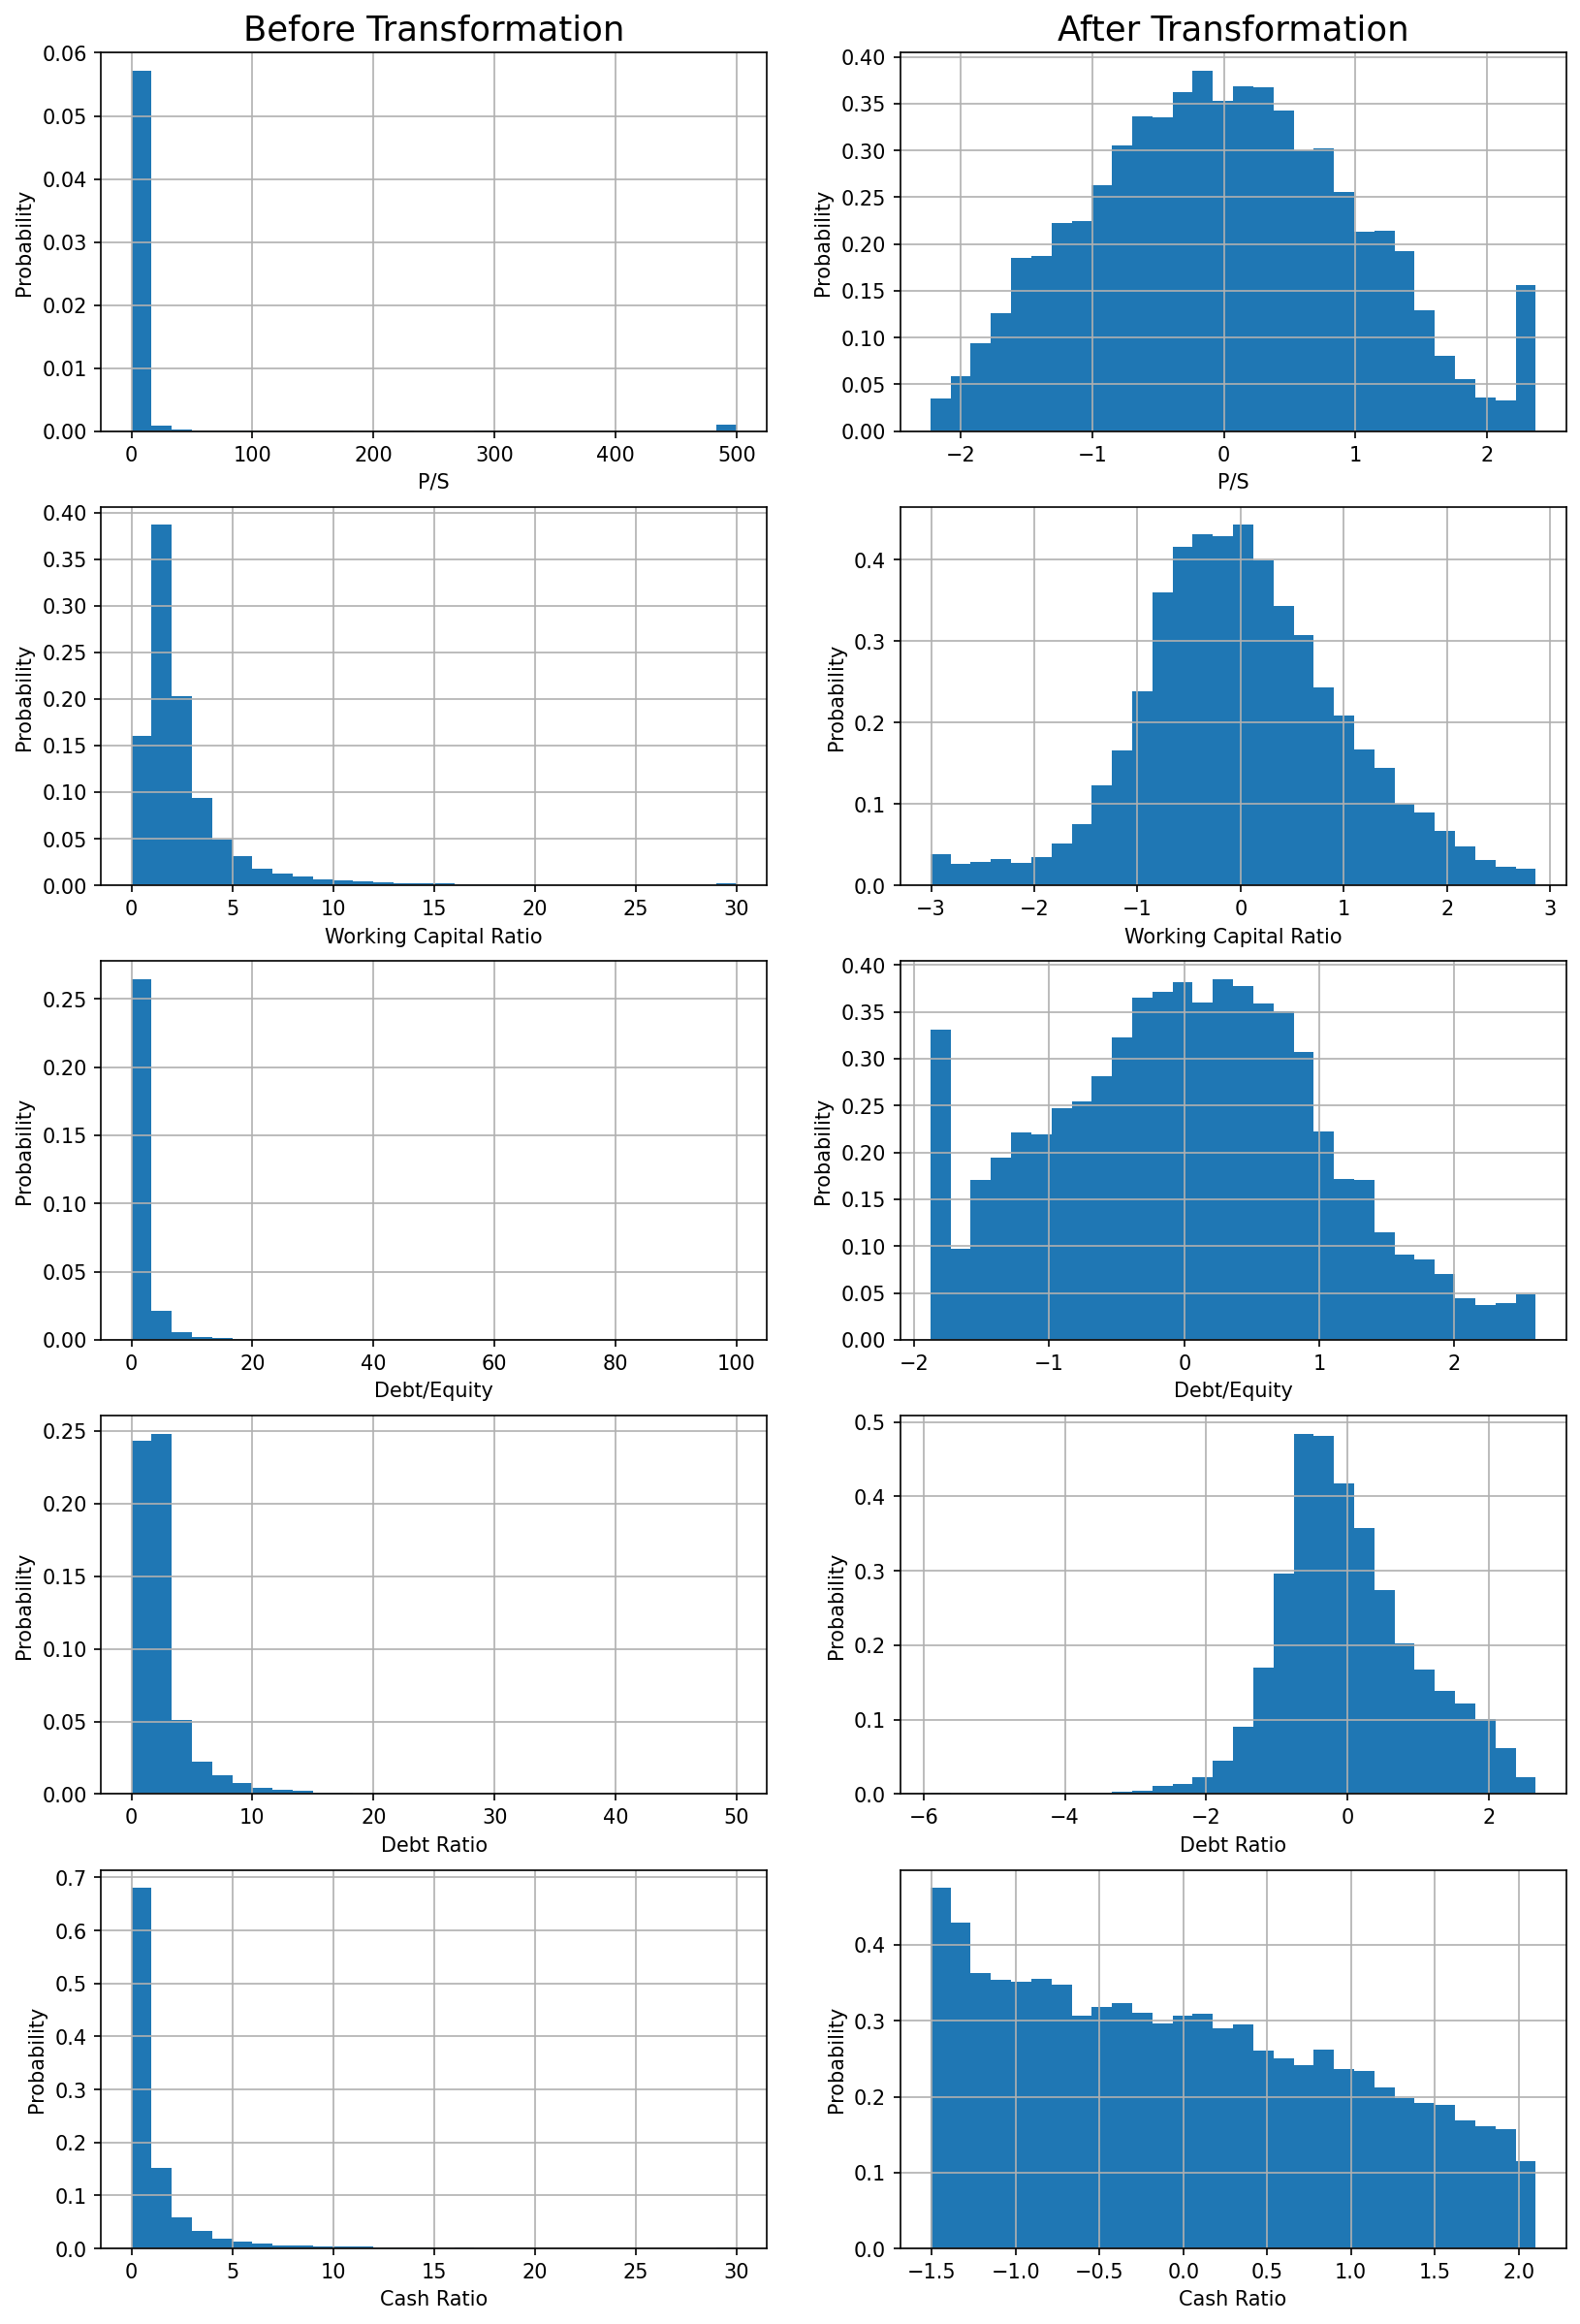

In [7]:
# Normalize data using sklearn PowerTransform

transformer = PowerTransformer()
transform_x = pd.DataFrame(transformer.fit_transform(x), columns=x.keys())

def plotFunc(n, df):
    myKey = df.keys()[n]
    plt.hist(df[myKey], density=True, bins=30)
    plt.grid()
    plt.xlabel(myKey)
    plt.ylabel('Probability')

plt.figure(figsize=(13,20))
plotsIwant=[4,6,9,10,11]

j=1

# Plotting the distributions
for i in plotsIwant:
    plt.subplot(len(plotsIwant), 2, 2*j-1)
    plotFunc(i, x)
    if j==1:
        plt.title('Before Transformation',fontsize=17)
    plt.subplot(len(plotsIwant),2,2*j)
    plotFunc(i,transform_x)
    if j==1:
        plt.title('After Transformation',fontsize=17)
    j+=1
    
plt.savefig('Transformat_Dists.png', dpi=300)

In [36]:
def loadxandy():
    '''
    Load X and y.
    Randomises rows.
    Returns X, y.
    '''
    # Read in data
    X=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv",
                  index_col=0)
    y=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv",
                  index_col=0)
    y=y["Performance"] # We only need the % returns as target
    
    # randomize the rows
    X['y'] = y
    X = X.sample(frac=1.0, random_state=42) # randomize the rows
    y = X['y']
    X.drop(columns=['y'], inplace=True)
    
    return X, y

x, y = loadxandy()
print('Baseline return: ', y.mean())

Baseline return:  0.13017422256200079


In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

print('X training matrix dimensions: ', x_train.shape)
print('X testing matrix dimensions: ', x_test.shape)
print('y training matrix dimensions: ', y_train.shape)
print('y testing matrix dimensions: ', y_test.shape)

X training matrix dimensions:  (14143, 18)
X testing matrix dimensions:  (1572, 18)
y training matrix dimensions:  (14143,)
y testing matrix dimensions:  (1572,)


In [35]:
# Linear regression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

pipeline = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('linear', LinearRegression())
])

pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
print('Train MSE: ', mean_squared_error(y_train, pipeline.predict(x_train)))
print('Test MSE: ', mean_squared_error(y_test, y_pred))

# the error terms change quite alot depending on the random state of the rows
# we split the data into various training and testing sizes to observe if there is any predictive abilities.
# sckit learning_curve allows us to do train/test runs in parrallel to speed things up

sizesToTrain = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8]

train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    pipeline,
    x,
    y,
    cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42),
    scoring = 'neg_mean_squared_error',
    n_jobs = 4,
    train_sizes = sizesToTrain,
    return_times = True
)

results_df = pd.DataFrame(index=train_sizes)
results_df['train_scores_mean'] = np.sqrt(-np.mean(train_scores,axis=1))
results_df['train_scores_std'] = np.std(np.sqrt(-train_scores), axis=1)
results_df['test_scores_mean'] = np.sqrt(-np.mean(test_scores, axis=1))
results_df['test_scores_std'] = np.std(np.sqrt(-test_scores), axis=1)
results_df['fit_times_mean'] = np.mean(fit_times, axis=1)
results_df['fit_times_std'] = np.std(fit_times, axis=1)
results_df

Train MSE:  0.31041762310261334
Test MSE:  0.3386839510617951


,train_scores_mean,train_scores_std,test_scores_mean,test_scores_std,fit_times_mean,fit_times_std
125,0.483306,0.141092,60.524043,60.118707,0.142236,0.093428
251,0.537369,0.153978,0.728109,0.195754,0.156305,0.100522
628,0.544559,0.108021,0.603838,0.075510,0.176567,0.087675
1257,0.547140,0.079403,0.582421,0.062620,0.223361,0.107088
2514,0.554834,0.060459,0.569264,0.058409,0.281300,0.091108
6286,0.554887,0.033637,0.561176,0.051967,0.513802,0.151401
10057,0.557156,0.018827,0.560219,0.052277,0.718015,0.171844


Text(0.5, 1.0, 'Linear Regression Learning Curve')

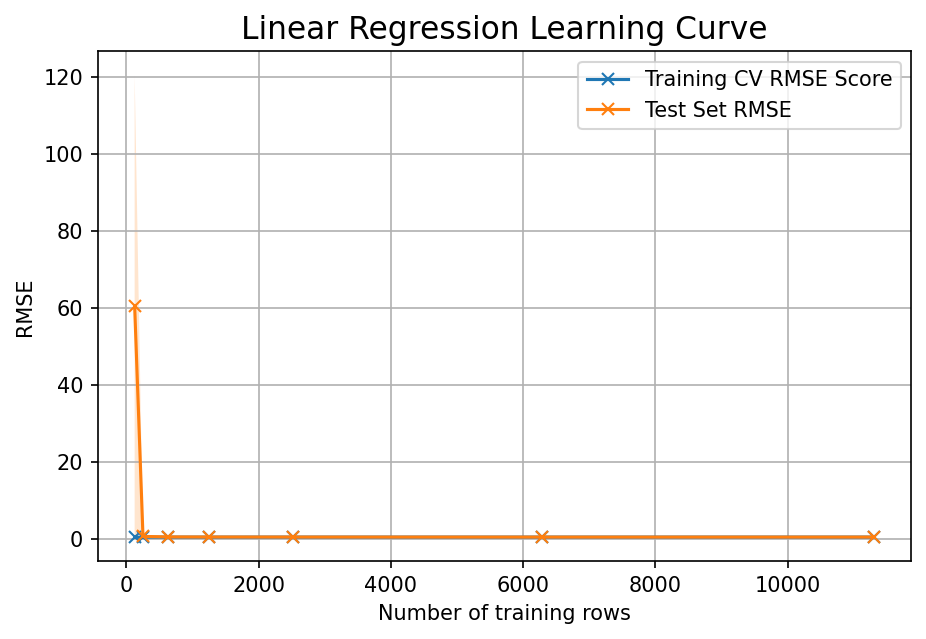

In [34]:
results_df['train_scores_mean'].plot(style='-x')
results_df['test_scores_mean'].plot(style='-x')
plt.fill_between(results_df.index,
                 results_df['train_scores_mean'] - results_df['train_scores_std'],
                 results_df['train_scores_mean'] + results_df['train_scores_std'],
                 alpha=0.2)

plt.fill_between(results_df.index,
                 results_df['test_scores_mean'] - results_df['test_scores_std'],
                 results_df['test_scores_mean'] + results_df['test_scores_std'],
                 alpha=0.2)
plt.grid()
plt.legend(['Training CV RMSE Score','Test Set RMSE'])
plt.ylabel('RMSE')
plt.xlabel('Number of training rows')
plt.title('Linear Regression Learning Curve', fontsize=15)
#plt.ylim([0, 1.25]);”

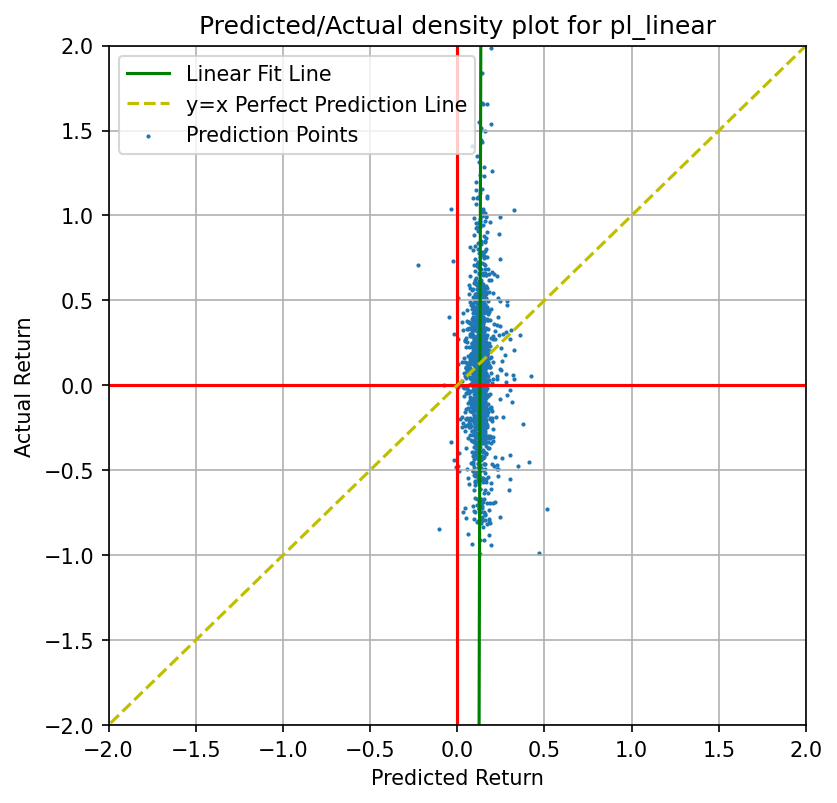

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def plotDensityContourPredVsReal(model_name, x_plot, y_plot, ps):
    # Plotting scatter 
    plt.scatter(x_plot, y_plot, s=1)
    # Plotting linear regression
    # Swap X and Y fit because prediction is quite centered around one value.
    LinMod = LinearRegression().fit(y_plot.reshape(-1, 1), x_plot.reshape(-1, 1))
    xx=[[-5],[5]]
    yy=LinMod.predict(xx)
    plt.plot(yy,xx,'g')
    # Plot formatting
    plt.grid()
    plt.axhline(y=0, color='r', label='_nolegend_')
    plt.axvline(x=0, color='r', label='_nolegend_')
    plt.xlabel('Predicted Return')
    plt.ylabel('Actual Return')
    plt.plot([-100,100],[-100,100],'y--')
    plt.xlim([-ps,ps])
    plt.ylim([-ps,ps])
    plt.title('Predicted/Actual density plot for {}'.format(model_name))
    plt.legend(['Linear Fit Line','y=x Perfect Prediction Line','Prediction Points'])
    # Save Figure
    #plt.figure(figsize=(5,5))
    plt.savefig(path + 'result.png')
    
plt.figure(figsize=(6,6))
plotDensityContourPredVsReal('pl_linear', y_pred, y_test.to_numpy(), 2)